In [13]:
import dingo
import os
import cobra
import pickle
import numpy as np
import seaborn as sn
import matplotlib.pylab as plt

In [3]:
main_path = '/'.join(os.getcwd().split("/")[:-1])

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

Sample without maximizing for any particular reaction.
To do so, set a zero vector as the objective function. 
The default objective function of the model is VBOF.

In [ ]:
# Load model
model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# Set the unbiased objective function
zero_biomass_function = np.zeros( model.num_of_reactions() )
model.set_biomass_function = zero_biomass_function

Now sample on the flux space in an unbiased way as no maximization is performed. 
In case, `gurobi` is not available, use the `set_slow_mode()` function, otherwise mute this line.

In [ ]:
# Generate steady states - 
sampler = dingo.PolytopeSampler(model)
sampler.set_slow_mode()
unbiased_steady_states = sampler.generate_steady_states()

with open("unbiased_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
     pickle.dump(unbiased_steady_states, dingo_steadystates_file)

Now, let us sample after maximizing the virus biomass (VBOF).

In [24]:
# Load model
vbof_model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# Get information about the biomass functions
covid_biomass_index = vbof_model.biomass_index
human_biomass_index = covid_biomass_index - 1

Set parameter Username


VBOF is already the objective function of your model. 

In [ ]:
# Sample optimal steady states when the objective function represents the virus' growth rate
vbof_sampler = dingo.PolytopeSampler(vbof_model)
vbof_sampler.set_slow_mode()
steady_states_covid_max_biomass = vbof_sampler.generate_steady_states()

with open("max_vbof_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
         pickle.dump(steady_states_covid_max_biomass, dingo_steadystates_file)

For this case, you can also optimize your model; i.e. run FBA.  

In [40]:
# The dingo fba() function returns a tuple with a single element
vbof_fba = vbof_model.fba()[0]

Finally, sample after maximizing for the human biomass function. 

In [26]:
# Load model
human_biomass_model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# set the objective function to be the human's biomass function
human_biomass_function = np.zeros(human_biomass_model.num_of_reactions())
human_biomass_function[human_biomass_index] = 1
human_biomass_model.set_biomass_function = human_biomass_function

Set parameter Username


Again, if you have `gurobi` mute the `set_slow_mode()` function.

In [ ]:
# sample optimal steady states when the objective function is the human's biomass function
human_biomass_sampler =  dingo.PolytopeSampler(human_biomass_model)
human_biomass_sampler.set_slow_mode()
steady_states_human_max_biomass = human_biomass_sampler.generate_steady_states()

with open("max_human_biomass_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
         pickle.dump(steady_states_human_max_biomass, dingo_steadystates_file)

And, like in the vbof case, optimize your model with human biomass as the objective function.

In [39]:
human_biomass_fba = human_biomass_model.fba()[0]

In case samples are already saved as above, you can just load your samples by running: 

In [21]:
unbiased_steady_states = pickle.load(open( "sars_samples/unbiased_sars_model_samples.pckl", "rb"))
vbof_max_samples = pickle.load(open("sars_samples/max_vbof_sars_model_samples.pckl", "rb"))
human_biomass_max_samples = pickle.load(open("sars_samples/max_human_biomass_sars_model_samples.pckl", "rb"))

Now, calculate the mean value of the flux value of each reaction.

In [28]:
vbof_max_samples_mean = vbof_max_samples.mean( axis = 1 )
human_biomass_max_samples_mean = human_biomass_max_samples.mean( axis = 1)

And plot an histogram for each of these cases to see the distribution. 

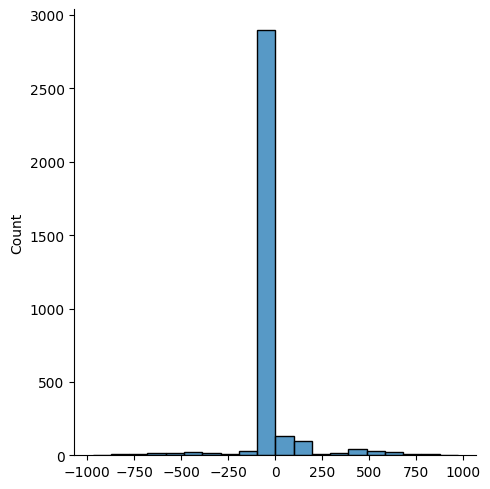

In [32]:
sn.displot(vbof_max_samples_mean, bins=20)

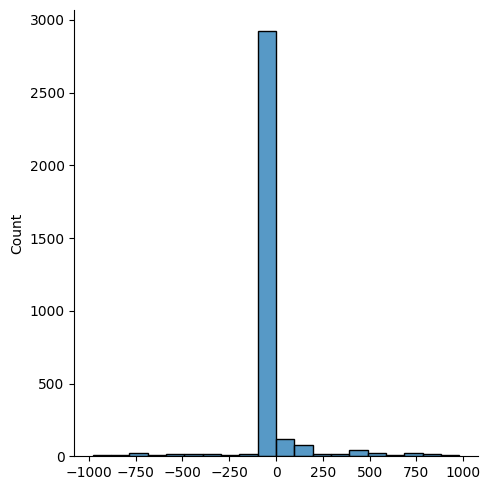

In [34]:

sn.displot(human_biomass_max_samples_mean, bins=20)

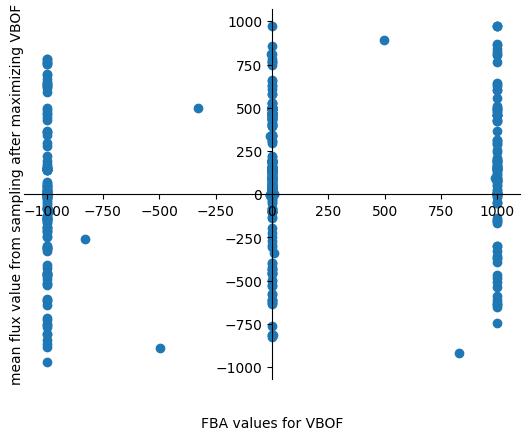

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('FBA values for VBOF')
plt.ylabel('mean flux value from sampling after maximizing VBOF')
ax.xaxis.set_label_coords(0.5, -.1)
ax.yaxis.set_label_coords(0, 0.5)
plt.scatter(x = vbof_fba, y = vbof_max_samples_mean)